<h3>In this code, we attempt to classify ships from SAR Images</h3>

In [17]:
import matplotlib.pyplot as plt 
import numpy as np 
import cv2 
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import load_img, img_to_array
import glob
import matplotlib.image as mpimg
from skimage.transform import resize
from skimage.color import gray2rgb


In [18]:
import os
import tifffile as tiff
import numpy as np
from PIL import Image

def split_image_to_fixed_size(image_path, tile_size, output_folder):
    """
    Splits an image into smaller images of a fixed size and saves them to a specified folder.

    Args:
        image_path (str): Path to the input image.
        tile_size (tuple): Size of each tile (width, height).
        output_folder (str): Folder to save the smaller images.

    Returns:
        None
    """
    # Read the input image using tifffile
    image = tiff.imread(image_path)
    image_height, image_width = image.shape[:2]

    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Calculate the size of each tile
    tile_width, tile_height = tile_size

    # Split the image into smaller images and save them
    for top in range(0, image_height, tile_height):
        for left in range(0, image_width, tile_width):
            right = min(left + tile_width, image_width)
            bottom = min(top + tile_height, image_height)

            # Crop the image
            cropped_image = image[top:bottom, left:right]

            # Convert the cropped image to a PIL image and save it
            cropped_image_pil = Image.fromarray(np.uint8(cropped_image))
            output_file = os.path.join(output_folder, f'image_{top}_{left}.png')
            cropped_image_pil.save(output_file)

# Example usage:
image_path = 's1a-iw-grd-vh-20240316t012643-20240316t012711-053000-066aa0-002.tiff'
tile_size = (256, 256)
output_folder = 'output_tiles'
split_image_to_fixed_size(image_path, tile_size, output_folder)


Input Images


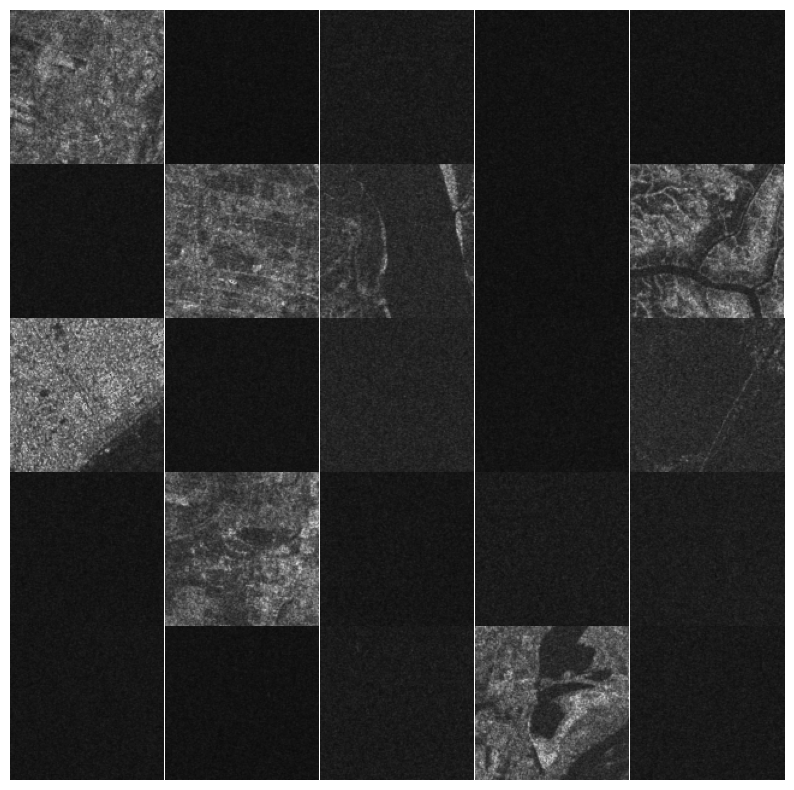

In [19]:
print("Input Images")

# Use glob to find all image files in the specified directory and its subdirectories
multipleImages = glob.glob('output_tiles/**/*.*', recursive=True)

# Filter out directories from the list of paths
image_files = [f for f in multipleImages if os.path.isfile(f)]

# Initialize counter for the subplot index
i = 0

# Set the figure size for the entire plot
plt.rcParams['figure.figsize'] = (10.0, 10.0)

# Adjust the layout of the subplots
plt.subplots_adjust(wspace=0, hspace=0)

# Loop through the first 25 images (or fewer if there are less than 25 images)
for im in image_files[:25]:
    # Read the image
    image = mpimg.imread(im)
    
    # Resize the image to 128x128
    image_resized = resize(image, (128, 128))
    
    # Convert grayscale images to RGB
    if len(image_resized.shape) == 2:  # If the image has only 2 dimensions, it's grayscale
        image_resized = gray2rgb(image_resized)

    # Display the image in the appropriate subplot
    plt.subplot(5, 5, i + 1)
    plt.imshow(image_resized)
    plt.axis('off')
    
    # Increment the subplot index
    i += 1

# Show the plot with all subplots
plt.show()


In [20]:
def predictions(model, img_path,IMG_SIZE):
    image = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    preds = model.predict(image)
    i = np.argmax(preds[0])
    return i

In [21]:
from tensorflow.keras.models import load_model
land_model = load_model('sar_land.h5')

In [ ]:
import os
import shutil
from PIL import Image
import numpy as np

def land_removal(source_folder):
    """
    Moves images classified as land to another folder.
    """

    # Ensure the destination folder exists
    os.makedirs(destination_folder, exist_ok=True)

    for filename in os.listdir(source_folder):
        file_path = os.path.join(source_folder, filename)
        
        try:
            with Image.open(file_path) as img:
                if predictions(land_model, file_path, 100) == 0:
                    # Move the file to the destination folder
                    os.remove(file_path)
                    print(f"Deleted {file_path}")
                    
        except Exception as e:
            print(f"Error processing {filename}: {e}")

# Example usage
source_folder = 'output_tiles'  # Change this to your source folder

land_removal(source_folder)


1/1 [==============================] - 0s 121ms/step
Deleted output_tiles/image_5120_6912.png
1/1 [==============================] - 0s 19ms/step
Deleted output_tiles/image_1536_256.png
1/1 [==============================] - 0s 18ms/step
Deleted output_tiles/image_9472_6144.png
1/1 [==============================] - 0s 18ms/step
Deleted output_tiles/image_2048_17152.png
1/1 [==============================] - 0s 18ms/step
Deleted output_tiles/image_6656_3328.png
1/1 [==============================] - 0s 18ms/step
Deleted output_tiles/image_1280_3840.png
1/1 [==============================] - 0s 17ms/step
Deleted output_tiles/image_2304_7168.png
1/1 [==============================] - 0s 18ms/step
Deleted output_tiles/image_5376_1536.png
1/1 [==============================] - 0s 18ms/step
Deleted output_tiles/image_4096_6144.png
1/1 [==============================] - 0s 18ms/step
Deleted output_tiles/image_1536_18176.png
1/1 [==============================] - 0s 19ms/step
Deleted output_t

In [23]:
ship_model = load_model('sar_ships.h5')

In [24]:
import os
import shutil
from PIL import Image
import numpy as np

def ship_classify(source_folder, destination_folder):
    """
    Moves images classified as ship to another folder.

    Args:
        source_folder (str): Path to the folder containing the images.
        destination_folder (str): Path to the folder to move ship images to.

    Returns:
        None
    """

    # Ensure the destination folder exists
    os.makedirs(destination_folder, exist_ok=True)

    for filename in os.listdir(source_folder):
        file_path = os.path.join(source_folder, filename)
        
        try:
            with Image.open(file_path) as img:
                if predictions(ship_model, file_path, 100) == 1:
                    # Move the file to the destination folder
                    shutil.move(file_path, os.path.join(destination_folder, filename))
                    print(f"Moved {filename} to {destination_folder}")
                    
        except Exception as e:
            print(f"Error processing {filename}: {e}")

# Example usage
source_folder = 'output_tiles'  # Change this to your source folder
destination_folder = 'ship_images'  # Change this to your destination folder

ship_classify(source_folder, destination_folder)


1/1 [==============================] - 0s 23ms/step
Moved image_18688_24064.png to ship_images
1/1 [==============================] - 0s 18ms/step
Moved image_4864_17664.png to ship_images
1/1 [==============================] - 0s 26ms/step
Moved image_2560_12544.png to ship_images
1/1 [==============================] - 0s 17ms/step
Moved image_256_20992.png to ship_images
1/1 [==============================] - 0s 18ms/step
Moved image_1792_14336.png to ship_images
1/1 [==============================] - 0s 16ms/step
Moved image_3584_18176.png to ship_images
1/1 [==============================] - 0s 18ms/step
Moved image_12544_13056.png to ship_images
1/1 [==============================] - 0s 22ms/step
Moved image_4608_20992.png to ship_images
1/1 [==============================] - 0s 17ms/step
Moved image_2048_21760.png to ship_images
1/1 [==============================] - 0s 21ms/step
Moved image_2816_19712.png to ship_images
1/1 [==============================] - 0s 18ms/step
Moved i

Ship Images


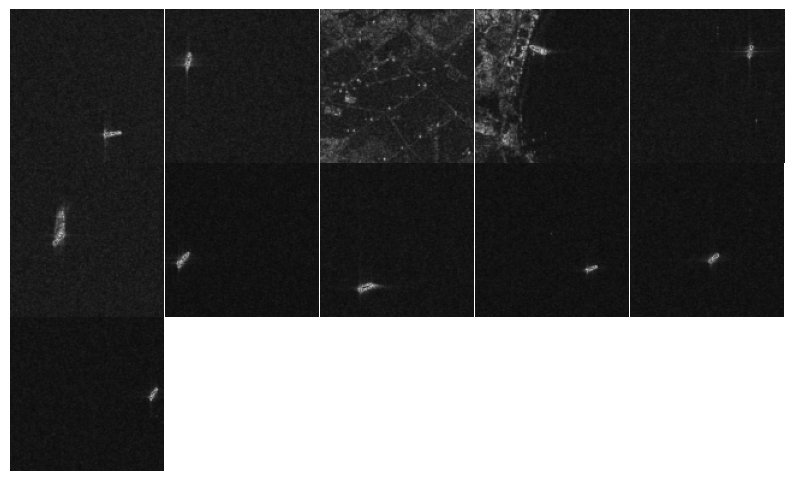

In [32]:
print("Ship Images")

# Use glob to find all image files in the specified directory and its subdirectories
multipleImages = glob.glob('ship_images/**/*.*', recursive=True)

# Filter out directories from the list of paths

image_files = [f for f in multipleImages if os.path.isfile(f)]

# Initialize counter for the subplot index
i = 0

# Set the figure size for the entire plot
plt.rcParams['figure.figsize'] = (10.0, 10.0)

# Adjust the layout of the subplots
plt.subplots_adjust(wspace=0, hspace=0)

# Loop through the first 25 images (or fewer if there are less than 25 images)
for im in image_files[:25]:
    # Read the image
    image = mpimg.imread(im)
    
    # Resize the image to 128x128
    image_resized = resize(image, (128, 128))
    
    if len(image_resized.shape) == 2:  # If the image has only 2 dimensions, it's grayscale\
        image_resized = gray2rgb(image_resized)
    # Display the image in the appropriate subplot
    plt.subplot(5, 5, i + 1)
    plt.imshow(image_resized)
    plt.axis('off')
    
    # Increment the subplot index
    i += 1

# Show the plot with all subplots
plt.show()


In [26]:
import cv2
import imutils
import matplotlib.pyplot as plt

def detect_and_display_objects(image_path):
    """
    Processes an image to detect objects and display lengths in pixels.

    Args:
        image_path (str): Path to the image file.

    Returns:
        None
    """
    # Read image and preprocess
    image = cv2.imread(image_path)
    if image is None:
        print(f"Could not read image {image_path}. Exiting.")
        return

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (9, 9), 0)

    edged = cv2.Canny(blur, 50, 100)
    edged = cv2.dilate(edged, None, iterations=1)
    edged = cv2.erode(edged, None, iterations=1)

    # Find contours
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    if not cnts:
        print("No objects found. Exiting.")
        return

    # Draw rectangles around objects and display lengths in pixels
    for cnt in cnts:
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 1)

        # Calculate length in pixels
        length_px = max(w, h)

        # Display length as text
        cv2.putText(image, "{:.2f} px".format(length_px), (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    # Convert image from BGR to RGB for displaying with Matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(5, 5))
    # Plot the image using Matplotlib
    plt.imshow(image_rgb)
    plt.title("Detected Objects with Lengths (px)")
    plt.axis('off')
    plt.show()


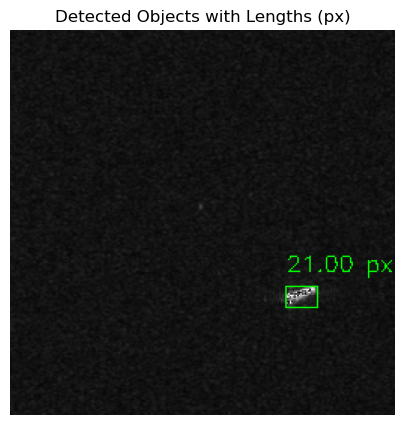

In [27]:
image_path = 'ship_images/image_2816_19712.png'
detect_and_display_objects(image_path)

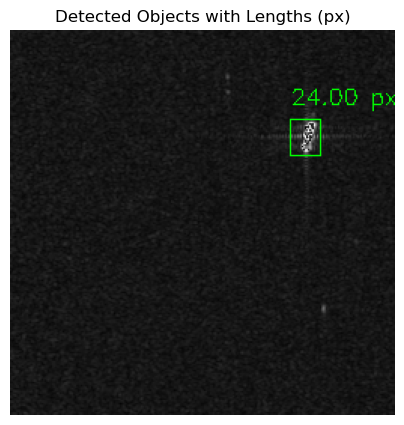

In [28]:
image_path = 'ship_images/image_3584_18176.png'
detect_and_display_objects(image_path)